In [19]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
import math

In [20]:
maze = np.zeros((500, 500), dtype=np.uint8)
cv2.rectangle(maze, (100, 200), (400, 300), 255, -1)
cv2.rectangle(maze, (300, 250), (500, 270), 255, -1)  
cv2.rectangle(maze, (250, 300), (270, 500), 255, -1)  
cv2.rectangle(maze, (100, 230), (0, 160), 255, -1)    

obstacles = np.where(maze == 0)

In [21]:
start = (250, 250)

In [23]:
escape_zones = [
    ((490, 250), (500, 270)),  
    ((250, 490), (270, 500)), 
    ((0, 180), (10, 200)),     
]

escape_targets = [
    (495, 260),  
    (260, 495),  
    (5, 190),    
]

def draw_map(obstacles):
    img = np.ones((500, 500), dtype=np.uint8) * 255
    img[obstacles] = 0
    plt.imshow(img, cmap='gray')
    plt.title("Maze with Obstacles")
    plt.show()

def in_escape_zone(point, zone):
    x, y = point
    (x1, y1), (x2, y2) = zone
    return x1 <= x <= x2 and y1 <= y <= y2

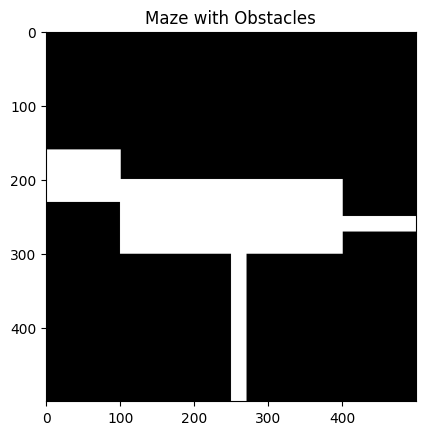

In [24]:
draw_map(obstacles)

In [25]:
class Node:
    def __init__(self, point, parent=None):
        self.point = point
        self.parent = parent

class RRT:
    def __init__(self, start, map_img, max_iter=1000, step_size=10):
        self.start = Node(start)
        self.map = map_img
        self.max_iter = max_iter
        self.step_size = step_size
        self.nodes = [self.start]

    def distance(self, p1, p2):
        return np.linalg.norm(np.array(p1) - np.array(p2))

    def is_free(self, p):
        x, y = int(p[0]), int(p[1])
        if 0 <= x < self.map.shape[1] and 0 <= y < self.map.shape[0]:
            return self.map[y, x] != 0
        return False

    def get_random_point(self):
        return (random.randint(0, self.map.shape[1] - 1), random.randint(0, self.map.shape[0] - 1))

    def nearest(self, point):
        return min(self.nodes, key=lambda node: self.distance(node.point, point))

    def steer(self, from_node, to_point):
        vec = np.array(to_point) - np.array(from_node.point)
        dist = np.linalg.norm(vec)
        if dist == 0:
            return from_node.point
        direction = vec / dist
        new_point = np.array(from_node.point) + self.step_size * direction
        return tuple(map(int, new_point))

    def run(self, start, goal=None):
        self.nodes = [Node(start)]
        for i in range(self.max_iter):
            rand_point = goal if goal else self.get_random_point()
            nearest_node = self.nearest(rand_point)
            new_point = self.steer(nearest_node, rand_point)
            if self.is_free(new_point):
                new_node = Node(new_point, nearest_node)
                self.nodes.append(new_node)
                if goal and self.distance(new_point, goal) < self.step_size:
                    return self.extract_path(new_node)
        return self.extract_path(self.nodes[-1])

    def extract_path(self, node):
        path = []
        while node:
            path.append(node.point)
            node = node.parent
        return path[::-1]

    def draw(self, path=None, goal=None):
        img = cv2.cvtColor(self.map.copy(), cv2.COLOR_GRAY2BGR)

        # Kreslení stromu
        for node in self.nodes:
            if node.parent:
                cv2.line(img, node.point, node.parent.point, (200, 200, 200), 1)

        # Cíl
        if goal:
            cv2.circle(img, goal, 5, (0, 0, 255), -1)

        # Cesta
        if path:
            for i in range(len(path) - 1):
                cv2.line(img, path[i], path[i + 1], (0, 255, 0), 2)

        # Start
        cv2.circle(img, self.start.point, 5, (255, 0, 0), -1)

        # Zobrazit
        plt.figure(figsize=(8, 8))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title("RRT Path Visualization")
        plt.axis("off")
        plt.show()


 Test escape zone 1 → cil: (495, 260)
Run 1: End point: (493, 259)
Detekováno v escape zone 1


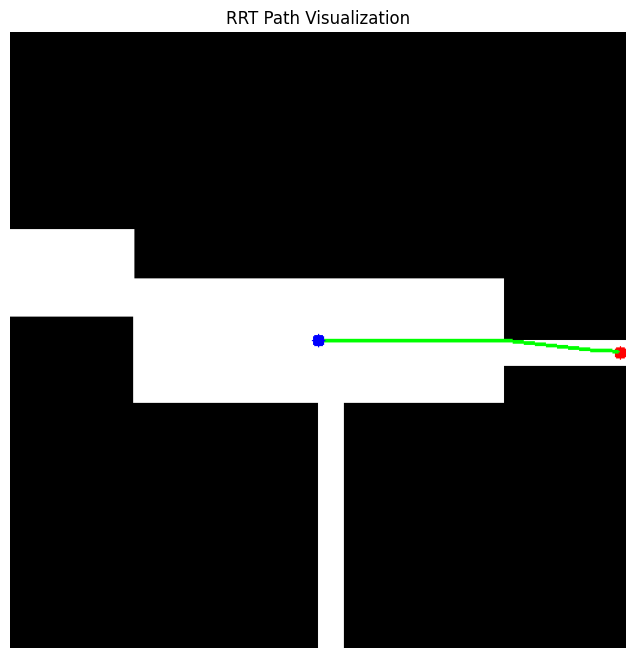


 Test escape zone 2 → cil: (260, 495)
Run 1: End point: (259, 493)
Detekováno v escape zone 2


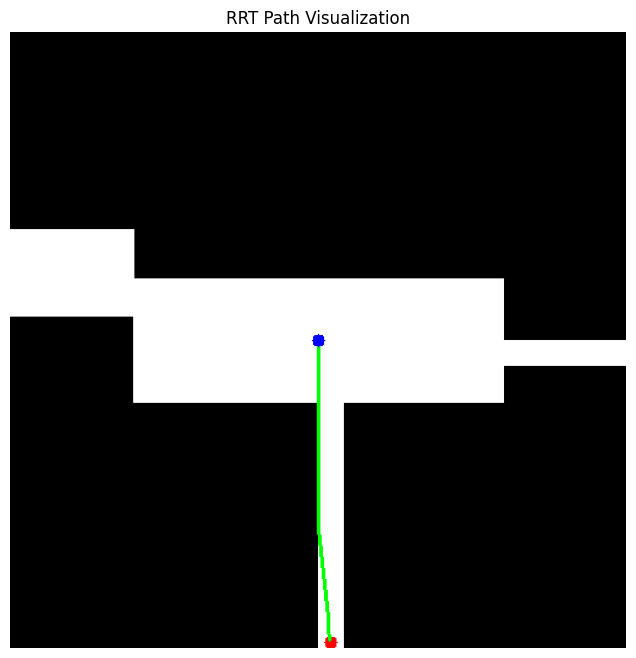


 Test escape zone 3 → cil: (5, 190)
Run 1: End point: (10, 191)
Detekováno v escape zone 3


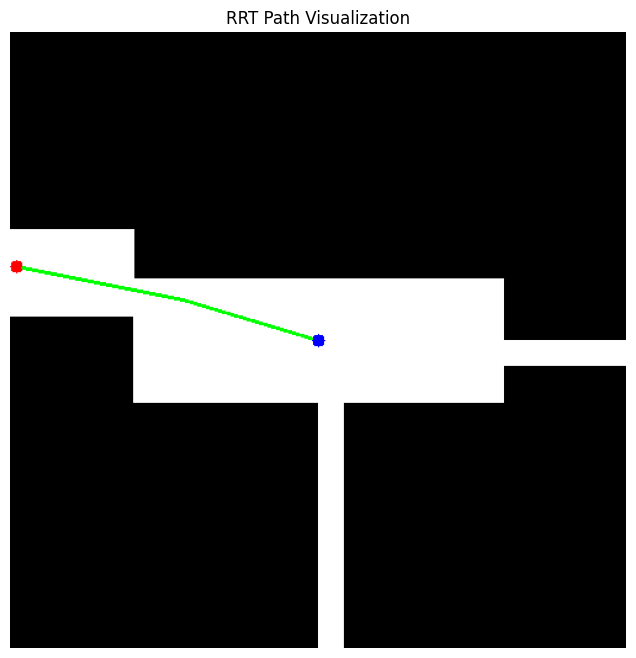


Výsledek detekce:
Escape 1: Nalezeno
Escape 2: Nalezeno
Escape 3: Nalezeno

 Vsechny tunely byly detekovany.


In [26]:
rrt = RRT(start=start, map_img=maze, step_size=10)
detected_escapes = [False, False, False]
success_count = 0

for i, target in enumerate(escape_targets):
    print(f"\n Test escape zone {i+1} → cil: {target}")
    for run in range(7):
        path = rrt.run(start, goal=target)
        if path:
            end_point = path[-1]
            print(f"Run {run+1}: End point: {end_point}")
            if in_escape_zone(end_point, escape_zones[i]):
                print(f"Detekováno v escape zone {i+1}")
                detected_escapes[i] = True
                success_count += 1
                rrt.draw(path=path, goal=target)
                break

print("\nVýsledek detekce:")
for i, detected in enumerate(detected_escapes):
    print(f"Escape {i+1}: {'Nalezeno' if detected else 'Nenalezen'}")

if all(detected_escapes):
    print("\n Vsechny tunely byly detekovany.")
else:
    print("\n Nektere tunely nebyly nalezeny.")